# The AutoEncoder

## Imports

In [42]:
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.callbacks import Callback
import numpy as np
from dotdict import dotdict as dd
import matplotlib.pyplot as plt
from random import randint


## Setup W&B

In [43]:
import wandb
from wandb.keras import WandbCallback

## Add Noise

In [44]:
def add_noise(x_train, x_test):
    # Add some random noise to an image

    noise_factor = 0.5
    x_train_noisy = x_train + noise_factor * \
        np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + noise_factor * \
        np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    return x_train_noisy, x_test_noisy


## Load, Add Noise, Normalise Data

Because Autoencoders are unsupervised learning algorithms, we don't need the labels for this dataset.

In [53]:
(x_train, _), (x_test, _) = mnist.load_data()

(x_train_noisy, x_test_noisy) = add_noise(x_train, x_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

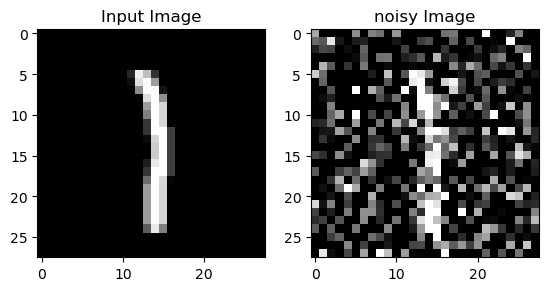

In [46]:
i = randint(0, len(x_train))
input_img = x_train[i]
noisy_input_img = x_train_noisy[i]
input_img = x_train[i]

# Plot the input and output images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_img, cmap='gray')
plt.title('Input Image')
plt.subplot(1, 3, 2)
plt.imshow(noisy_input_img, cmap='gray')
plt.title('noisy Image')
plt.show()


## Explore normalisation pre-post noise
Note: no training possible with current architecture and post-normalisation noise. Too Noisy?

| Adding Noise Before Normailisation | Adding Noise After Normailisation |
|------------------------------------|-----------------------------------|
|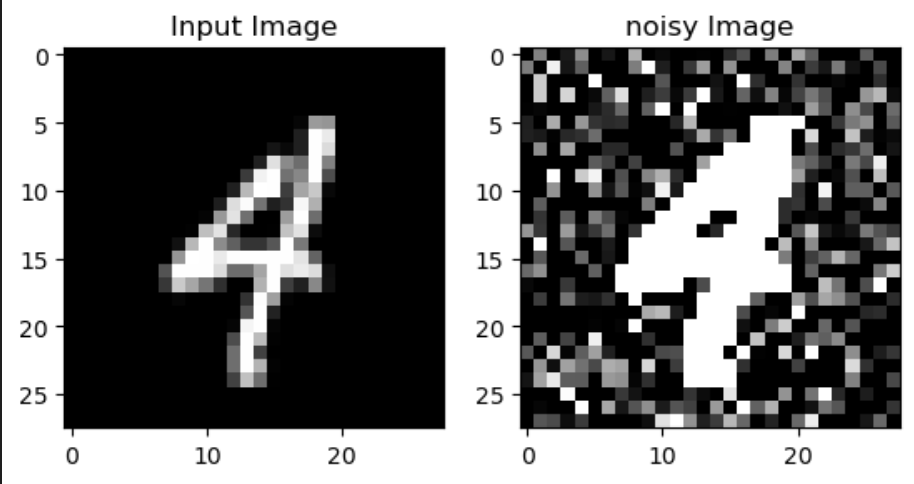 | 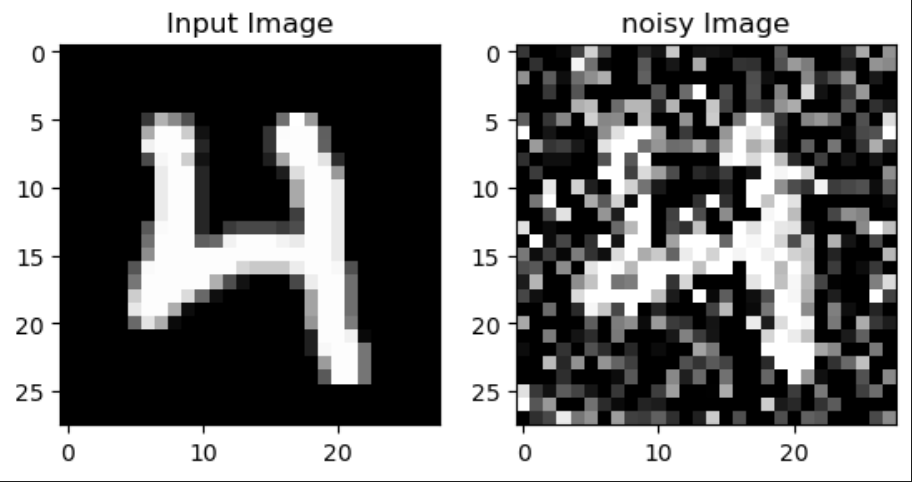 |

## Model Config

The encoding dimension is the most important hyperparameter (or variables) in the autoencoder.

In [47]:
config = dd.Dict()
config.encoding_dim = 32
config.epochs = 10


## Build the Model (Without Convolutions)

In [48]:
# model = Sequential()
# model.add(Flatten(input_shape=(28,28)))
# model.add(Dense(config.encoding_dim, activation='relu'))
# model.add(Dense(28*28, activation='sigmoid'))
# model.add(Reshape((28,28)))
# model.compile(optimizer='adam', loss='mse')

## Build the Model (With Convolutions)

In [49]:
model = Sequential()
model.add(Reshape((28, 28, 1), input_shape=(28, 28)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
model.add(Reshape((28, 28)))

model.compile(optimizer='adam', loss='mse')

## Check the Model

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 1)        

## Create Callback for W&B image logging

In [51]:
# For visualization
class Images(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
           
    def on_epoch_end(self, epoch, logs):
        indices = np.random.randint(self.validation_data[0].shape[0], size=8)
        test_data = self.validation_data[0][indices]
        pred_data = self.model.predict(test_data)
        wandb.log({
            "examples": [
                  wandb.Image(np.hstack([data, pred_data[i]]), caption=str(i))
                  for i, data in enumerate(test_data)]},
              step=epoch)


## Train the Model

In [52]:
# Init W&B
run = wandb.init(config=config)

# Train the model
model.fit(x_train_noisy, x_train,
          epochs=config.epochs,
          validation_data=(x_test_noisy, x_test),
          callbacks=[Images((x_test_noisy, x_test)), WandbCallback()])

# Finish the W&B run
run.finish()  

Epoch 1/10
   1/1875 [..............................] - ETA: 8:23 - loss: 0.2077

2023-02-01 13:31:16.544772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1874/1875 [============================>.] - ETA: 0s - loss: 0.1123

2023-02-01 13:31:36.639892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 52ms/step


2023-02-01 13:31:38.428109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 23s 12ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 2/10
1/1 [==============================] - 0s 15ms/steps - loss: 0.11


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 23s 12ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
1/1 [==============================] - 0s 16ms/steps - loss: 0.11


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 23s 12ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
1/1 [==============================] - 0s 14ms/steps - loss: 0.11


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_133114-nnj50c8h/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 23s 12ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
1522/1875 [=======================>......] - ETA: 3s - loss: 0.1120

KeyboardInterrupt: 

## Results

| Without Noisy Input |
| --- | 
| 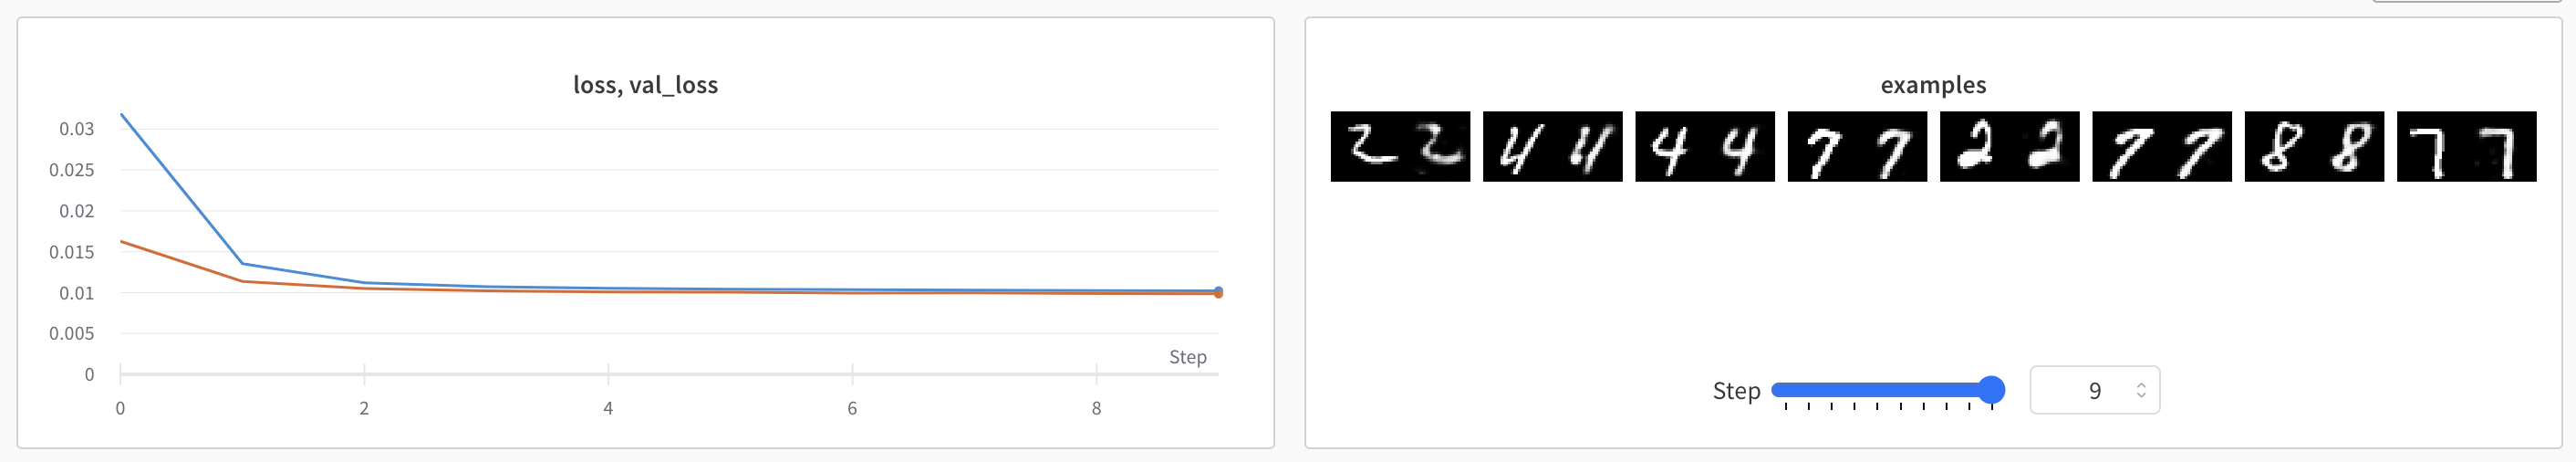 |
| With Noisy Input |
| 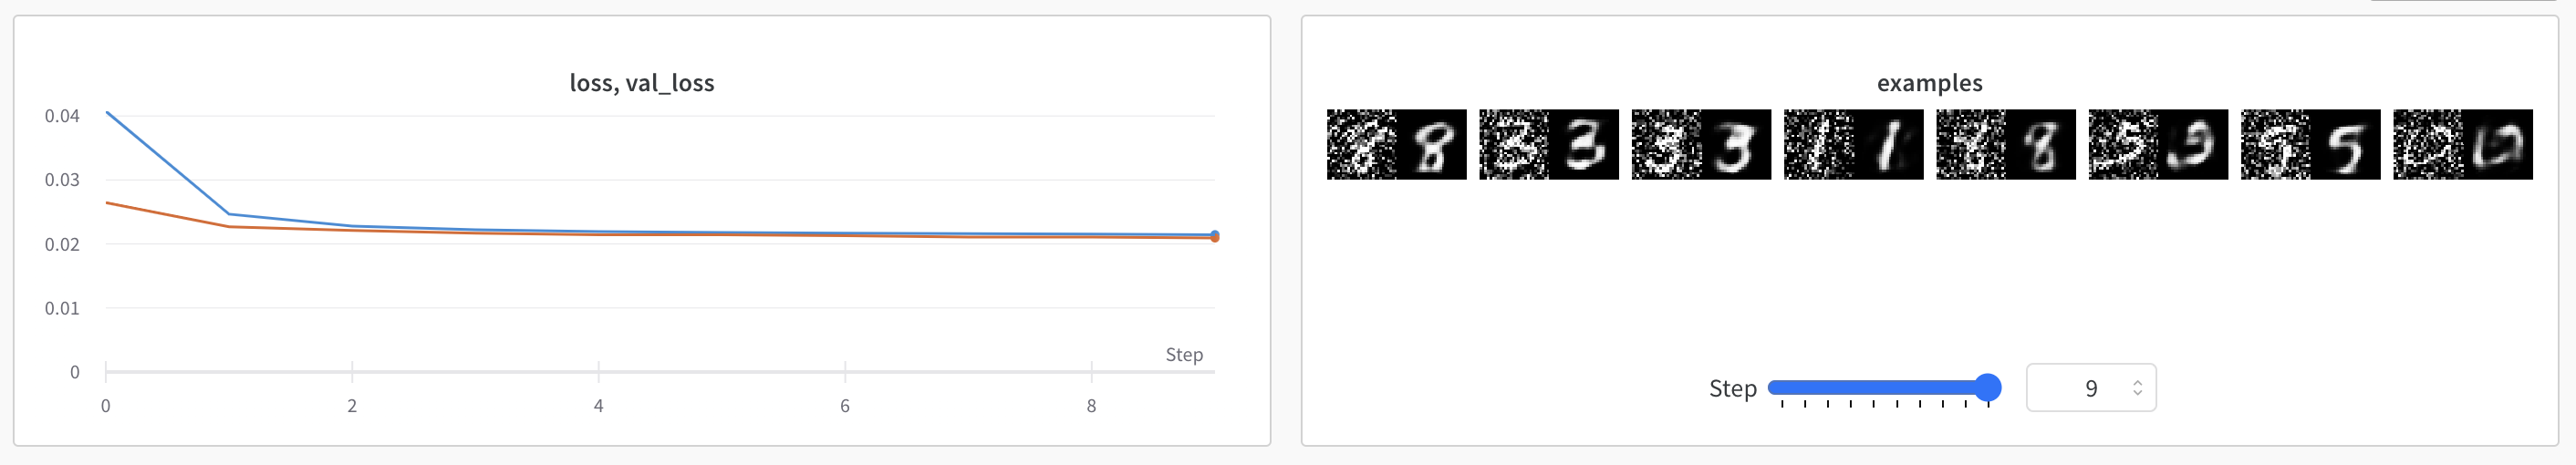 |
| With Noisy Input and Convolutional Layers |
| 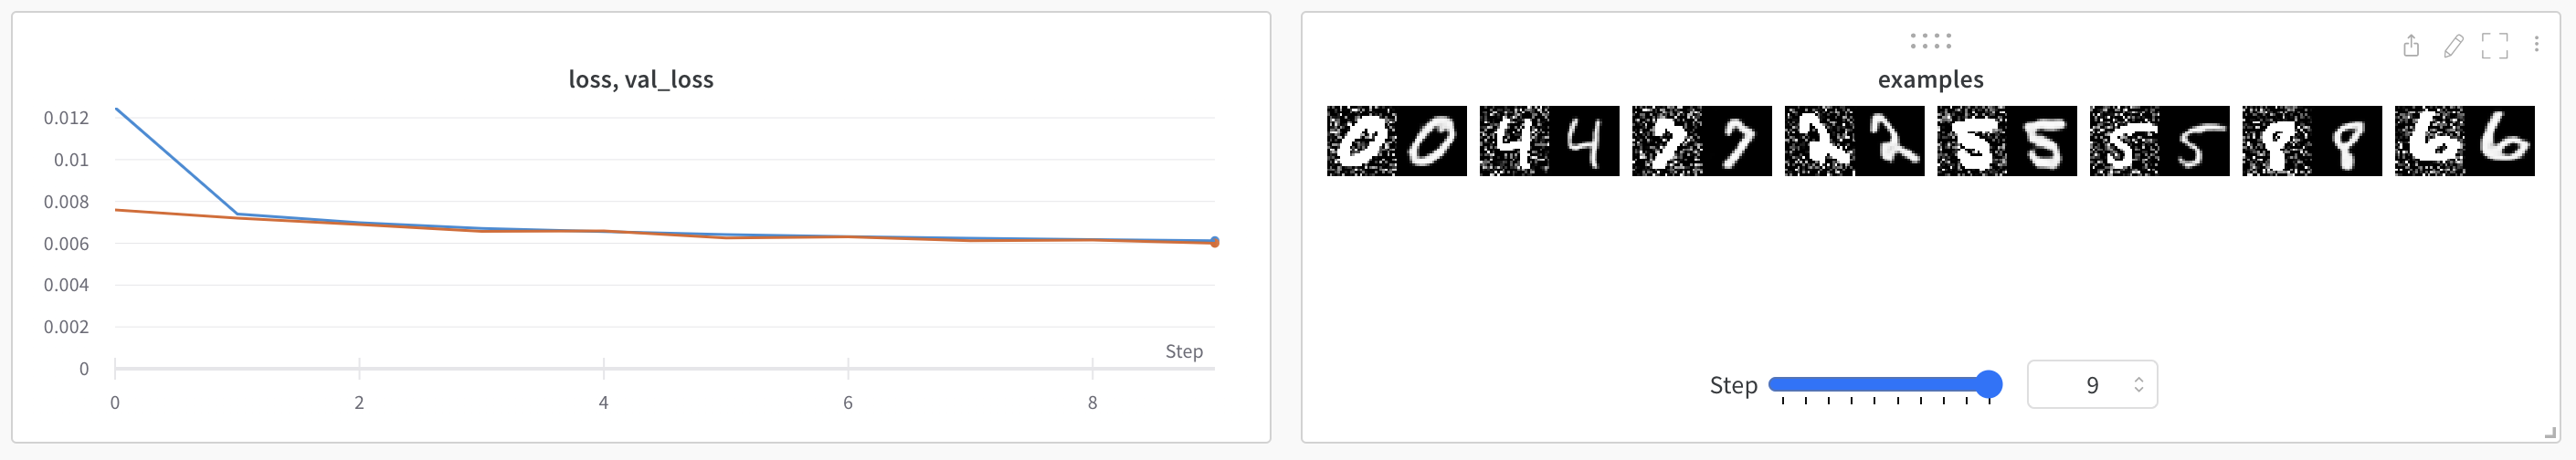 |

## Save the model

In [ ]:
model.save('auto-encoder-denoiser-CNN.h5')